# BakerZ, Inc. Expansion Strategy for Toronto and New York

## IBM Data Science Capstone Project
## Shail Rajput

### Introduction/Business Problem

BakerZ, Inc. is a multi-national corporation that specializes in wholesale manufacturing and distribution of fine baked goods to coffee shops including sandwiches, cakes, pastries, and cookies. Quality, freshness, and punctual delivery of the product have been their key success factors is sustaining their customers. These are the factors that BakerZ does not compromise on.

BakerZ is now looking at expanding their business to New York, NY in the USA and Toronto, ON in Canada. They have tasked us to determine the best neighborhood locations in Toronto and New York where they can set up distribution centers.

Their requirements for each distribution center are as follows:
* It should serve multiple neighborhoods with the maximum number of coffee shops that are closest to each other
* It should only attempt to target neighborhoods with at least 10 or more coffee shops
* It should itself be located in the neighborhood with the maximum number of coffee shops

Based on these requirements, BakerZ, Inc. has tasked us in determining how many distribution centers they should establish in Toronto and New York, and their neighborhood locations. For each city, they also want us to recommend a priority order in establishing the distribution centers so they have a better return on investment.

#### Import necessary python modules for data preperation, analysis, modeling, and visualization
#### Uncomment module installation as needed

In [1]:
# Import basic libraries, install ones that we need
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge lxml --yes
#!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import numpy as np
import folium
import requests
import lxml
import html
import json
from geopy.geocoders import Nominatim
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         392 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch

### Source Data, Prepare/Clean, and create consistent Dataframes for New York and Toronto
#### Establish Data Source for New York and Toronto

In [2]:
ny_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
toronto_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#### Download New York Data

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Process the New York data to create a dataframe

In [10]:
with open('newyork_data.json') as json_data:
    ny_data = json.load(json_data)
    
ny_neighborhoods_data = ny_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_ny = pd.DataFrame(columns=column_names)

for data in ny_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_ny = df_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
 
print('New York has {} boroughs and {} neighborhoods.'.format(
        len(df_ny['Borough'].unique()), df_ny.shape[0]))


New York has 5 boroughs and 306 neighborhoods.


#### Process the Toronto data to create a dataframe

Scrape the Wikipedia site to extract table as dataframe.

In [25]:
df_tor = pd.read_html(toronto_url, header=0)[0]
df_tor.head()
print('Toronto has {} boroughs and {} neighborhoods.'.format(
        len(df_tor['Borough'].unique()), df_tor.shape[0]))

Toronto has 11 boroughs and 180 neighborhoods.


#### Pre-process and clean Dataframe
1. We fix Neighbourhood (British spelling) column name to Neighborhood (American spelling) to be consistent
2. If any Neighborhood is not assigned but has a Borough, we use Borough name as Neighborhood name
3. Remove all rows where Borough is not assigned.
Note: In this data, all the Neighborhoods that are unassigned also have the Borough unassigned

In [26]:
df_tor = df_tor.rename(columns={'Postal Code':'Postal Code', 'Borough':'Borough','Neighbourhood':'Neighborhood'})
df_tor.head()

df_tor.loc[df_tor['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df_tor['Borough']
df_tor = df_tor[df_tor['Borough'] != 'Not assigned']
df_tor.head()

print('Toronto has {} boroughs and {} neighborhoods.'.format(
        len(df_tor['Borough'].unique()), df_tor.shape[0]))

Toronto has 10 boroughs and 103 neighborhoods.


#### Source Toronto Geo-location data from CSV file

Create new dataframe that maps Toronto Postal Codes to Latitude and Longitude values

In [28]:
!wget -q -O 'toronto_postal_code_geoloc.csv' https://cocl.us/Geospatial_data

df_pcode_geo = pd.read_csv('toronto_postal_code_geoloc.csv')
df_pcode_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Using Postal Code as the Key, we can now add Latitude and Longitude columns to our original Toronto dataframe

Inspect the first few rows of the data frame and also check the shape to make sure we still have the same number of rows

In [29]:
pcode_list = df_tor['Postal Code'].tolist()

for pcode in pcode_list:
    lat = df_pcode_geo.loc[df_pcode_geo['Postal Code'] == pcode, ['Latitude', 'Longitude']].iloc[0,0].round(6)
    lng = df_pcode_geo.loc[df_pcode_geo['Postal Code'] == pcode, ['Latitude', 'Longitude']].iloc[0,1].round(6)
    df_tor.loc[df_tor['Postal Code'] == pcode, 'Latitude'] = lat
    df_tor.loc[df_tor['Postal Code'] == pcode, 'Longitude'] = lng

df_tor = df_tor.reset_index(drop=True)
df_tor.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662302,-79.389494


In [30]:
df_tor.shape

(103, 5)

## Part 3: Create and look at visual maps of New York and Toronto neighborhoods

### Determine geolocation coordinates for Toronto

In [31]:
ny_addr = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(ny_addr)
ny_lat = location.latitude
ny_lng = location.longitude
print('New York geographical coordinates: {}, {}.'.format(ny_lat, ny_lng))

New York geographical coordinates: 40.7127281, -74.0060152.


In [32]:
tor_addr = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(tor_addr)
tor_lat = location.latitude
tor_lng = location.longitude
print('Toronto geographical coordinates: {}, {}.'.format(tor_lat, tor_lng))

Toronto geographical coordinates: 43.6534817, -79.3839347.


### Create a map of New York with all neighborhoods imposed on top

In [33]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[ny_lat, ny_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

### Create a map of Toronto with all neighborhoods imposed on top

In [34]:
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[tor_lat, tor_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

### Utilize Foursquare API to explore neighborhoods and segment them
#### Set up Foursquare credentials and version

In [35]:
CLIENT_ID = 'HIDDEN' # your Foursquare ID
CLIENT_SECRET = 'HIDDEN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HIDDEN
CLIENT_SECRET: HIDDEN


#### Retrieve Coffee Shop data for each neighborhood in New York using Foursquare API
We use a radius of 500 meters and limit the search to 100 venues

In [36]:
num_nhoods = df_ny.shape[0]
radius = 500
    
for i in range(num_nhoods):
    nlat = df_ny.loc[i, 'Latitude']
    nlng = df_ny.loc[i, 'Longitude']
    nname = df_ny.loc[i, 'Neighborhood']
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, nlat, nlng, 'Coffee', radius, LIMIT)
    results = requests.get(url).json()
    nshops = len(results['response']['venues'])
    df_ny.loc[i, 'NumCoffeeShops'] = nshops
    
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,Bronx,Wakefield,40.894705,-73.847201,0.0
1,Bronx,Co-op City,40.874294,-73.829939,0.0
2,Bronx,Eastchester,40.887556,-73.827806,0.0
3,Bronx,Fieldston,40.895437,-73.905643,1.0
4,Bronx,Riverdale,40.890834,-73.912585,2.0


#### BakerZ does not want to cater to neighborhoods that have less than 10 Coffee Shops
Create new dataframes for New York and Toronto that filter away neighborhoods that don't meet this criteria.
Also, sort the dataframe in descending order of number of coffee shops.

In [42]:
df_ny_sorted = df_ny.sort_values(by='NumCoffeeShops', ascending=False)
df_ny_i = df_ny_sorted.loc[df_ny_sorted['NumCoffeeShops'] >= 10, ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'NumCoffeeShops']].reset_index(drop=True)

print('New York has {} neighborhoods with more than 10 Coffee Shops.'.format(df_ny_i.shape[0]))
df_ny_i.head(20)

New York has 38 neighborhoods with more than 10 Coffee Shops.


,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,Manhattan,Murray Hill,40.748303,-73.978332,50.0
1,Manhattan,Greenwich Village,40.726933,-73.999914,50.0
2,Manhattan,Flatiron,40.739673,-73.990947,50.0
3,Manhattan,Midtown,40.754691,-73.981669,50.0
4,Manhattan,Soho,40.722184,-74.000657,50.0
5,Manhattan,Midtown South,40.748510,-73.988713,50.0
6,Manhattan,Financial District,40.707107,-74.010665,50.0
7,Manhattan,Chelsea,40.744035,-74.003116,48.0
8,Manhattan,Civic Center,40.715229,-74.005415,46.0
9,Manhattan,Little Italy,40.719324,-73.997305,41.0


In [51]:
num_nhoods = df_tor.shape[0]
radius = 500
    
for i in range(num_nhoods):
    nlat = df_tor.loc[i, 'Latitude']
    nlng = df_tor.loc[i, 'Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, nlat, nlng, 'Coffee', radius, LIMIT)
    results = requests.get(url).json()
    nshops = len(results['response']['venues'])
    df_tor.loc[i, 'NumCoffeeShops'] = nshops

df_tor.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,12.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662302,-79.389494,14.0


In [52]:
df_tor_sorted = df_tor.sort_values(by='NumCoffeeShops', ascending=False)
df_tor_i = df_tor_sorted.loc[df_tor_sorted['NumCoffeeShops'] >= 10, ['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 'NumCoffeeShops']].reset_index(drop=True)
print('Toronto has {} neighborhoods with more than 10 Coffee Shops.'.format(df_tor_i.shape[0]))
df_tor_i.head(20)

Toronto has 15 neighborhoods with more than 10 Coffee Shops.


,Postal Code,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,43.0
1,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,40.0
2,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,39.0
3,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,35.0
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,32.0
5,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0
6,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,26.0
7,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,26.0
8,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,14.0
9,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662302,-79.389494,14.0


#### Visualizations for New York and Toronto mapping Neighborhoods that have more than 10 Coffee Shops

In [53]:
# create map of New York using latitude and longitude values
map_ny_i = folium.Map(location=[ny_lat, ny_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_ny_i['Latitude'], df_ny_i['Longitude'], df_ny_i['Borough'], df_ny_i['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny_i)  
    
map_ny_i

In [55]:
# create map of Toronto using latitude and longitude values
map_tor_i = folium.Map(location=[tor_lat, tor_lng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor_i['Latitude'], df_tor_i['Longitude'], df_tor_i['Borough'], df_tor_i['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor_i)  
    
map_tor_i

### Applying Machine Learning to Cluster Neighborhoods that have the most Coffee Shops and are also closest to each other

#### We use DBSCAN - a form of unsupervised machine learning to create clusters of neighborhoods
#### A critical parameter for DBSCAN is the Epsilon whose value is data dependent
#### We shall find the best Epsilon value to use by leveraging the NearestNeighbors module from sklearn
#### After fitting our core normalized cost data (Number of Coffee Shops, Latitude, Longitude), we shall plot it
#### The best Epsilon value is obtained from the Elbow point of the plot.

##### Determine Epsilon for New York Data

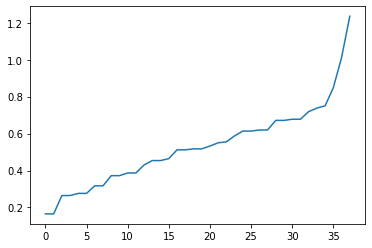

In [56]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

sklearn.utils.check_random_state(1000)

db_dataset = df_ny_i[['NumCoffeeShops', 'Latitude','Longitude']]

# Clean and normalize the data
db_dataset = np.nan_to_num(db_dataset)
db_dataset = StandardScaler().fit_transform(db_dataset)

# Fit the model and apply it to our dataset
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(db_dataset)
distances, indices = nbrs.kneighbors(db_dataset)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the data to determine Epsilon value to use for New York data
plt.plot(distances)

##### We can see best Epsilon value is about 0.75 at the Elbow
##### Now we are ready to run DBSCAN for New York

##### We also prepare a new Dataframe that has a ClusterID column that indicates the cluster label to which a neighborhood belongs. Outlier Neighborhoods (with label -1 are removed from the dataframe.

In [67]:
sklearn.utils.check_random_state(1000)

# Prepare normalized data
db_dataset = df_ny_i[['NumCoffeeShops', 'Latitude','Longitude']]
db_dataset = np.nan_to_num(db_dataset)
db_dataset = StandardScaler().fit_transform(db_dataset)

# Run DBSCAN with Epsilon as 0.75. Since we have 38 NY neighborhoods, we keep minimum neighborhoods in cluster to 3
db = DBSCAN(eps=0.75, min_samples=3).fit(db_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_ny_i['ClusterID']=labels

num_clusters_ny = len(set(labels)) - (1 if -1 in labels else 0)

# Remove outliers where label is -1
df_ny_clstrs = df_ny_i.loc[df_ny_i['ClusterID'] != -1, ['ClusterID', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 'NumCoffeeShops']].reset_index(drop=True)

print('Number of Neighborhood Clusters in New York is {}'.format(num_clusters_ny))
# Check the new dataframe
df_ny_clstrs

Number of Neighborhood Clusters in New York is 3


,ClusterID,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,0,Manhattan,Murray Hill,40.748303,-73.978332,50.0
1,0,Manhattan,Greenwich Village,40.726933,-73.999914,50.0
2,0,Manhattan,Flatiron,40.739673,-73.990947,50.0
3,0,Manhattan,Midtown,40.754691,-73.981669,50.0
4,0,Manhattan,Soho,40.722184,-74.000657,50.0
5,0,Manhattan,Midtown South,40.748510,-73.988713,50.0
6,0,Manhattan,Financial District,40.707107,-74.010665,50.0
7,0,Manhattan,Chelsea,40.744035,-74.003116,48.0
8,0,Manhattan,Civic Center,40.715229,-74.005415,46.0
9,0,Manhattan,Little Italy,40.719324,-73.997305,41.0


##### Determine Epsilon for Toronto Data

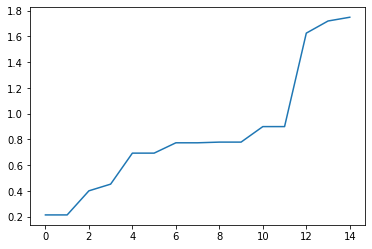

In [59]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

sklearn.utils.check_random_state(1000)

# Prepare normalized data
db_dataset = df_tor_i[['NumCoffeeShops', 'Latitude','Longitude']]

# Clean and normalize the data
db_dataset = np.nan_to_num(db_dataset)
db_dataset = StandardScaler().fit_transform(db_dataset)

# Fit the model and apply it to our dataset
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(db_dataset)
distances, indices = nbrs.kneighbors(db_dataset)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the data to determine Epsilon value to use for New York data
plt.plot(distances)

##### We can see best Epsilon value is about 0.90 at the Elbow
##### Now we are ready to run DBSCAN for Toronto

##### We also prepare a new Dataframe that has a ClusterID column that indicates the cluster label to which a neighborhood belongs. Outlier Neighborhoods (with label -1 are removed from the dataframe.

In [66]:
sklearn.utils.check_random_state(1000)

# Prepare normalized data
db_dataset = df_tor_i[['NumCoffeeShops', 'Latitude','Longitude']]
db_dataset = np.nan_to_num(db_dataset)
db_dataset = StandardScaler().fit_transform(db_dataset)

# Run DBSCAN with Epsilon as 0.90. Since we have 15 Toronto neighborhoods, we keep minimum neighborhoods in cluster to 2
db = DBSCAN(eps=0.90, min_samples=2).fit(db_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_tor_i['ClusterID']=labels

num_clusters_tor = len(set(labels)) - (1 if -1 in labels else 0)

# Remove outliers where label is -1
df_tor_clstrs = df_tor_i.loc[df_tor_i['ClusterID'] != -1, ['ClusterID', 'Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 'NumCoffeeShops']].reset_index(drop=True)

print('Number of Neighborhood Clusters in Toronto is {}'.format(num_clusters_tor))

# Check the new dataframe
df_tor_clstrs

Number of Neighborhood Clusters in Toronto is 5


,ClusterID,Postal Code,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,43.0
1,0,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,40.0
2,0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,39.0
3,0,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,35.0
4,1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,32.0
5,1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0
6,2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,26.0
7,2,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,26.0
8,3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,14.0
9,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662302,-79.389494,14.0


#### Visualize the Neighborhood Clusters for New York

In [63]:
# create map
map_clusters = folium.Map(location=[ny_lat, ny_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters_ny)
ys = [i + x + (i*x)**2 for i in range(num_clusters_ny)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_ny_clstrs['Latitude'], df_ny_clstrs['Longitude'], df_ny_clstrs['Neighborhood'], df_ny_clstrs['ClusterID']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Visualize the Neighborhood Clusters for Toronto

In [64]:
# create map
map_clusters = folium.Map(location=[tor_lat, tor_lng], zoom_start=14)

# set color scheme for the clusters
x = np.arange(num_clusters_tor)
ys = [i + x + (i*x)**3 for i in range(num_clusters_tor)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_tor_clstrs['Latitude'], df_tor_clstrs['Longitude'], df_tor_clstrs['Neighborhood'], df_tor_clstrs['ClusterID']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1

In [68]:
df_tor_clstrs.loc[df_tor_clstrs['ClusterID'] == 0, df_tor_clstrs.columns[[1] + list(range(5, df_tor_clstrs.shape[1]))]]

,Postal Code,Longitude,NumCoffeeShops
0,M5H,-79.384568,43.0
1,M5X,-79.382280,40.0
2,M5L,-79.379817,39.0
3,M5K,-79.381576,35.0


In [69]:
df_tor_clstrs

,ClusterID,Postal Code,Borough,Neighborhood,Latitude,Longitude,NumCoffeeShops
0,0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,43.0
1,0,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,40.0
2,0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,39.0
3,0,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,35.0
4,1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,32.0
5,1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,30.0
6,2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,26.0
7,2,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,26.0
8,3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,14.0
9,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662302,-79.389494,14.0


### Now we create a new Dataframe which combines the final data from New York and Toronto.
### This dataframe only picks the neighborhoods with the maximum number of coffee shops in each cluster.
### It also adds a column to indicate the total number of coffee shops in that neighborhood's cluster.
### Since we are combining data from two cities, it also adds a City column.
### BakerZ requested that their warehouses be located in the neighborhood with maximum number of coffee shops
### This information once sorted should provide the business insights that BakerZ needs.

In [123]:
df_combo = pd.DataFrame([], columns=['City', 'ClusterID', 'Neighborhood', 'NumCoffeeShops', 'TotalCoffeeShopsInCluster'])

for i in range(num_clusters_tor):
    df_exp = df_tor_clstrs.loc[df_tor_clstrs['ClusterID'] == i, ['ClusterID', 'Neighborhood', 'NumCoffeeShops']]
    df_exp = df_exp.loc[df_exp['NumCoffeeShops'] == max(df_exp['NumCoffeeShops']), ['ClusterID', 'Neighborhood', 'NumCoffeeShops']]
    tot_shops = df_tor_clstrs.groupby('ClusterID').sum().iloc[:, 2:3]['NumCoffeeShops'][i]
    df_exp.loc[df_exp['ClusterID'] == i, 'TotalCoffeeShopsInCluster'] = tot_shops
    df_exp.loc[df_exp['ClusterID'] == i, 'City'] = 'Toronto'
    df_combo = df_combo.append(df_exp, ignore_index=True)

for i in range(num_clusters_ny):
    df_exp = df_ny_clstrs.loc[df_ny_clstrs['ClusterID'] == i, ['ClusterID', 'Neighborhood', 'NumCoffeeShops']]
    df_exp = df_exp.loc[df_exp['NumCoffeeShops'] == max(df_exp['NumCoffeeShops']), ['ClusterID', 'Neighborhood', 'NumCoffeeShops']]
    tot_shops = df_ny_clstrs.groupby('ClusterID').sum().iloc[:, 2:3]['NumCoffeeShops'][i]
    df_exp.loc[df_exp['ClusterID'] == i, 'TotalCoffeeShopsInCluster'] = tot_shops
    df_exp.loc[df_exp['ClusterID'] == i, 'City'] = 'New York'
    df_combo = df_combo.append(df_exp, ignore_index=True)

df_combo

,City,ClusterID,Neighborhood,NumCoffeeShops,TotalCoffeeShopsInCluster
0,Toronto,0,"Richmond, Adelaide, King",43.0,157.0
1,Toronto,1,Central Bay Street,32.0,62.0
2,Toronto,2,St. James Town,26.0,52.0
3,Toronto,2,Stn A PO Boxes,26.0,52.0
4,Toronto,3,Berczy Park,14.0,27.0
5,Toronto,4,"Queen's Park, Ontario Provincial Government",14.0,25.0
6,New York,0,Murray Hill,50.0,593.0
7,New York,0,Greenwich Village,50.0,593.0
8,New York,0,Flatiron,50.0,593.0
9,New York,0,Midtown,50.0,593.0


### Our customer, BakerZ, requested a priority list for best order in which to open their Distribution Centers.
### We sort the combined neighborhoods from Toronto and New York on basis of Total Coffee Shops in their Cluster.
### This prioritized list should provide the best return on investment for BakerZ.

In [125]:
df_combo_priority = df_combo.sort_values(by='TotalCoffeeShopsInCluster', ascending=False).reset_index(drop=True)
df_combo_priority

,City,ClusterID,Neighborhood,NumCoffeeShops,TotalCoffeeShopsInCluster
0,New York,0,Murray Hill,50.0,593.0
1,New York,0,Greenwich Village,50.0,593.0
2,New York,0,Flatiron,50.0,593.0
3,New York,0,Midtown,50.0,593.0
4,New York,0,Soho,50.0,593.0
5,New York,0,Midtown South,50.0,593.0
6,New York,0,Financial District,50.0,593.0
7,Toronto,0,"Richmond, Adelaide, King",43.0,157.0
8,New York,1,Turtle Bay,35.0,154.0
9,Toronto,1,Central Bay Street,32.0,62.0


### End of Notebook, all Deliverables have been met above